## MNIST DATA SET

It is the data set of hand written digits
different handwritten forms of different digits
This needs the DNN to learn this data 

This data set is a  multiclass dataset. Here, we use softmax function as an activation function
Here we dont use the Sigmoid function because, Sigmoid function is predominately helpful in the binary classifications.
It is again available under the hood of pytorch.

The MNIST data is being inputted into the neural network as this way:

The images contained in the database are 28*28 pixels i.e. there are 784 pixels to be analysed. 
That means the input can be 784 input nodes to the DNN. 
Performance theory to be known how this actual multiclass classification occurs

The data to be splitted into train and test dataset

In [1]:
import torch
from torchvision import datasets, transforms ##contains transformations to apply on these images before supplying to the nn
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))#here the first tuple, to normalize all channel with means of, second is SD
                               ])## ToTensor converts the image to the tensor and characterizes the image as
                                    ##Channel (C), Height (H), Width(W)
    ## using the values -1, 1 reduces the skewness of the data, hence we apply the normalizations

training_dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [3]:
training_dataset
#we use training loader to import the dataset that convert the data to batches
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)#shuffle =true to remove the local minima stuck during the SGD

In [4]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy() #first dim= color, second= width, third =height, we know that in MNIST= it is (1, 28, 28)
#but, to plot our image, we need (28, 28, 1). So, Transform it.
    image= image.transpose(1, 2, 0) #swap axis 0 to 1 and 1 to 2 and 2 to 0
#normalizaion = Z= (x-mean)/SD. So, we do this:
    
    image =image*np.array((0.5, 0.5, 0.5))+ np.array((0.5, 0.5, 0.5))
    image=image.clip(0, 1) #to ensure the values are in betn 0 and 1
    return image

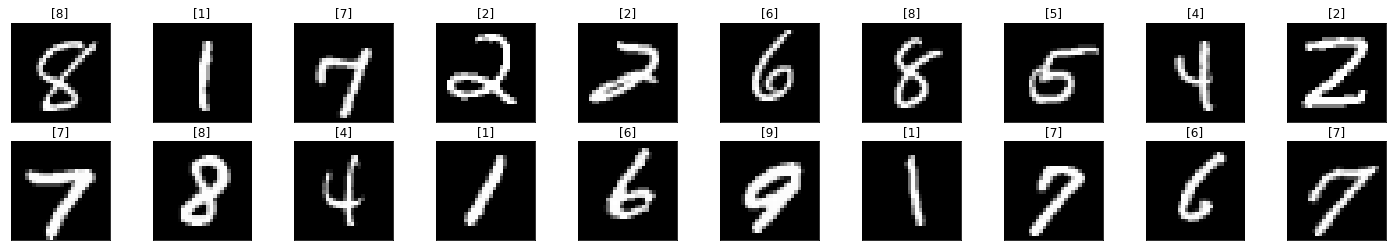

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()#grabs first batch of training data
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title([labels[idx].item()])

In [6]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1=nn.Linear(D_in, H1)
        self.linear2=nn.Linear(H1, H2)
        self.linear3=nn.Linear(H2, D_out)
    def forward(self, x):
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=self.linear3(x)
        return x

In [7]:
model=Classifier(784, 125, 65, 10)#as 10 classes so out=10
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [8]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs=12
running_loss_history=[]
running_corrects_history=[]
val_running_loss_history=[]
val_running_corrects_history=[]


for e in range(epochs):
    running_loss=0.0
    running_corrects=0.0
    val_running_loss=0.0
    val_running_corrects=0.0

    for inputs, labels in training_loader:
        inputs=inputs.view(inputs.shape[0], -1)
        #1, 28, 28 # we have to make it 1d by flattening to 784 pixels input
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds=torch.max(outputs, 1) ## here if the output is [2, 1, 0.1, ..... 10items], then the max of it indicates that the item belongs to that class            
        running_loss+=loss.item()#add up to batch iteration
        running_corrects+=torch.sum(preds==labels.data)
        
    ## after every epoch, validate using test set
    else:
        with torch.no_grad():#sets requires_grad flag to false as it is not needed here and saves the memory.
            for val_inputs, val_labels in validation_loader:
                val_inputs=val_inputs.view(val_inputs.shape[0], -1)
                val_outputs=model(val_inputs)
                val_loss=criterion(val_outputs, val_labels)                
                _, val_preds=torch.max(val_outputs, 1) ## here if the output is [2, 1, 0.1, ..... 10items], then the max of it indicates that the item belongs to that class            
                val_running_loss+=val_loss.item()#add up to batch iteration
                val_running_corrects+=torch.sum(val_preds==val_labels.data)
        
        epoch_loss=(running_loss)/len(training_loader)
        epoch_acc= (running_corrects.float())/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        print("EPOCH: ", e+1)
        print('training loss: {:.4f}, Train Accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        
        val_epoch_loss=(val_running_loss)/len(validation_loader)
        val_epoch_acc= (val_running_corrects.float())/len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('Validation loss: {:.4f}, Validation Accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

EPOCH:  1
training loss: 0.4224, Train Accuracy 87.8150
Validation loss: 0.2498, Validation Accuracy 92.5100
EPOCH:  2
training loss: 0.2069, Train Accuracy 93.7850
Validation loss: 0.1571, Validation Accuracy 95.2400
EPOCH:  3
training loss: 0.1496, Train Accuracy 95.4983
Validation loss: 0.1399, Validation Accuracy 95.7300
EPOCH:  4
training loss: 0.1177, Train Accuracy 96.3917
Validation loss: 0.1276, Validation Accuracy 96.0200
EPOCH:  5
training loss: 0.0992, Train Accuracy 96.9200
Validation loss: 0.1004, Validation Accuracy 97.0200
EPOCH:  6
training loss: 0.0844, Train Accuracy 97.3533
Validation loss: 0.1002, Validation Accuracy 96.8600
EPOCH:  7
training loss: 0.0778, Train Accuracy 97.4967
Validation loss: 0.1108, Validation Accuracy 96.7000
EPOCH:  8
training loss: 0.0700, Train Accuracy 97.7417
Validation loss: 0.0957, Validation Accuracy 97.1000
EPOCH:  9
training loss: 0.0630, Train Accuracy 97.9350
Validation loss: 0.0869, Validation Accuracy 97.3600
EPOCH:  10
training

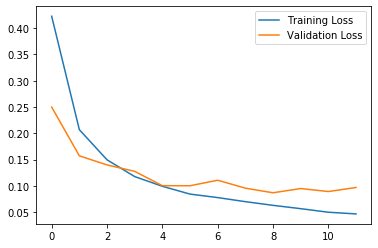

In [12]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

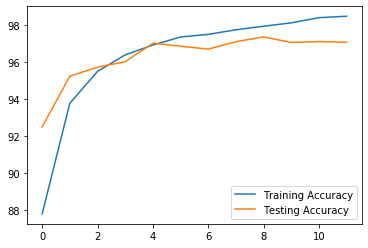

In [13]:
plt.plot(running_corrects_history, label="Training Accuracy")
plt.plot(val_running_corrects_history, label="Testing Accuracy")
plt.legend()

In [14]:
#https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg

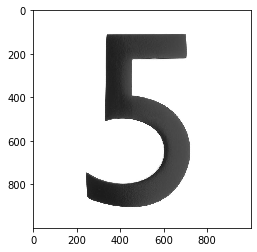

In [20]:
#testing using the images in the web
import requests
from PIL import Image
import PIL.ImageOps
url='https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response=requests.get(url, stream=True)
img=Image.open(response.raw)
plt.imshow(img)

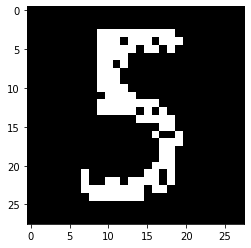

In [21]:
#preprocess it 
# to 28*28 grayscale  data
# first problem we identify here is that our images were with black bg with white images 
# where as here it is vice versa. SO, 
img=PIL.ImageOps.invert(img)
img=img.convert('1')#by 1- bilevel image (grayscale)
img=transform(img) #from the fun declared earlier in the beginning
plt.imshow(im_convert(img))

In [22]:
#now, feed it to the  nn.
img=img.view(img.shape[0], -1)
output=model(img)
_, pred=torch.max(output, 1)
print(pred.item())

5


##### HOORREEYYYY!! WE MADE IT!

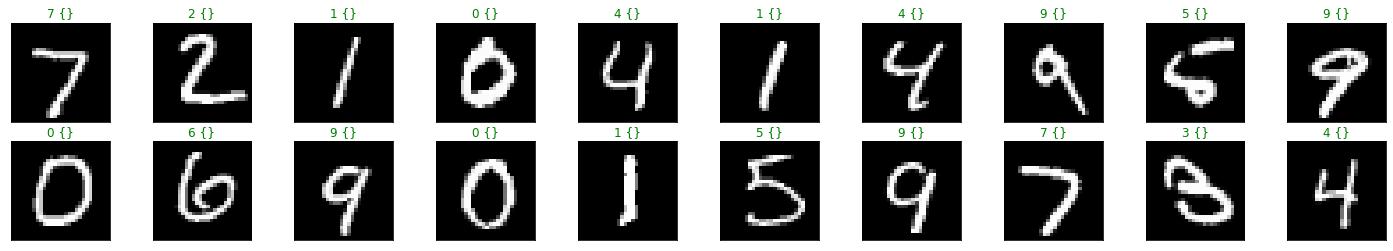

In [24]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()#grabs first batch of training data
images_=images.view(images.shape[0], -1)
output=model(images_)
_, preds=torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))#2 rows and 10 cols and index
    ax.set_title("{} {{}}".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))